In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing required librarires

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

#Reading the dataset

In [23]:
#read the data
df = pd.read_csv("/content/drive/MyDrive/Portfolio/Projects/Housing Price Prediction/EDA/eda_train.csv")
del df['Unnamed: 0']
#we dont need to apply any technique on house id, so lets remove it.
id =  df['Id']
del df['Id']
price = df['SalePrice']
del df['SalePrice']     ##no need to scale target variable
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Unknown,Reg,Lvl,AllPub,Inside,...,0,0,Unknown,MnPrv,Shed,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Unknown,Reg,Lvl,AllPub,FR2,...,0,0,Unknown,MnPrv,Shed,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,Unknown,IR1,Lvl,AllPub,Inside,...,0,0,Unknown,MnPrv,Shed,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,Unknown,IR1,Lvl,AllPub,Corner,...,0,0,Unknown,MnPrv,Shed,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,Unknown,IR1,Lvl,AllPub,FR2,...,0,0,Unknown,MnPrv,Shed,0,12,2008,WD,Normal


##Getting Categorical Columns

In [24]:
#fetching categorical columns
cat_cols = list(col for col in df.columns if df[col].dtype==object)
print(cat_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


Categorical data is divided into two types -
* Nominal categorical data - doesnt have meaningful order.
* Ordinal categorical data - has meaningful order.     
      
To differentiate our data columns into Nominal and Ordinal we have used Chi-square contigency test.

In [25]:
#create list for nominal and ordinal columns
nominal_cols = []
ordinal_cols = []

#add categorical columns with respect to thier category
for col in cat_cols:
    # Create a contingency table of the variable and the target variable
    contingency_table = pd.crosstab(df[col], price)

    # Perform the chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Determine whether the variable is nominal or ordinal based on the p-value
    if p > 0.05:
        #if p_value is greater than C.I. we add column into Nominal category
        nominal_cols.append(col)
    else:
        #if p_value is lesser than C.I. we add column into Ordinal category
        ordinal_cols.append(col)

#Data Preprocessing

We can utilize one-hot encoding for nominal columns since they lack meaningful order. This approach involves creating separate columns for each category within the column. On the other hand, for ordinal columns, we can employ label encoding, which assigns numerical values to the categories based on their order. This allows us to capture the inherent ordering within the column.

In [26]:
# perform one-hot encoding using pandas get_dummies function on nominal categorical variabels
df['Id'] = id
one_hot_encoded = pd.get_dummies(df[nominal_cols])
one_hot_encoded['Id'] = id
df = pd.merge(df, one_hot_encoded, on='Id', how='inner')

In [27]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each ordinal feature
for feature in ordinal_cols:
    df[feature + '_encoded'] = label_encoder.fit_transform(df[feature])


#Data Scaling
To standardize numerical columns, we can utilize the StandardScaler preprocessing technique. It scales the features by subtracting the mean and dividing by the standard deviation.
The formula is expressed as:           
`z = (x - u) / s`          
where           
- z is the standardized value,             
- x is the original value,             
- u is the mean, and                
- s is the standard deviation.     

StandardScaler ensures that the numerical features have a mean of 0 and a standard deviation of 1, making them comparable for machine learning algorithms.

In [28]:
#fetching numerical columns
num_cols = list(set(df.columns) - set(cat_cols))
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
final_cols = [ cols for cols in df.columns if cols not in cat_cols]
data = df[final_cols]


##Dimensionality Reduction
Dimensionality reduction is necessary to mitigate the curse of dimensionality, where high-dimensional data can lead to increased complexity and computational inefficiency. In order to address this, I will apply feature extraction technique, specifically PCA (Principal Component Analysis) algorithm, to reduce the dimensionality of the dataset while retaining the most important information and minimizing information loss.

In [29]:
# Instantiate PCA (Principal Component Analysis) object
pca = PCA()

# Apply PCA to the data
data_pca = pca.fit_transform(data.values)

# Calculate the explained variance ratio, which represents the proportion of variance explained by each principal component.
# This helps us understand how much information is retained in each component.
explained_var_ratio = pca.explained_variance_ratio_


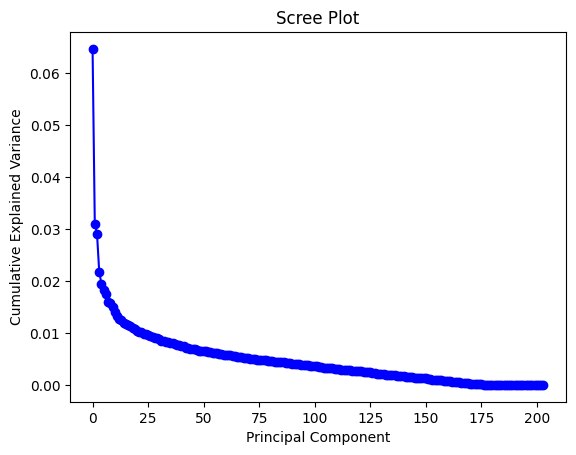

In [30]:
#plotting scree plot using matplotlib
num_components = len(explained_var_ratio)
index = np.arange(num_components)
plt.plot(index, explained_var_ratio, marker='o', linestyle='-', color='b')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

In [31]:
# Determine the ideal number of principal components using the elbow method
cumulative_var_ratio = np.cumsum(explained_var_ratio)
n_components = np.argmax(cumulative_var_ratio >= 0.95) + 1
n_components

130

**From both the scree plot and calculative method we can see that 130 principle component are enough to explain the maximum variance in data.**

In [32]:
pca = PCA(n_components=130)
data_pca = pca.fit_transform(data)

In [33]:
data_pca

array([[ 3.28150111, -1.83809675, -1.20626771, ...,  0.2009512 ,
        -0.45346027,  0.06919379],
       [-0.04009282,  1.84583354, -0.46074216, ...,  0.98573672,
         0.1058803 ,  0.43273774],
       [ 3.70244645, -1.43570054, -0.84817338, ...,  0.14886573,
        -0.01500622,  0.10965531],
       ...,
       [ 2.08872514, -1.97685765,  1.63169704, ..., -0.38314184,
         1.23037792,  0.91388314],
       [-2.87967576,  3.68064253, -0.98808931, ...,  0.11491479,
        -0.08547444,  0.27252867],
       [-0.85122377,  3.96440124, -0.89482429, ..., -1.23811279,
        -0.75038971, -0.21280707]])

In [34]:
np.savetxt('model_data.csv', data_pca, delimiter=',')